# Setting Up Simulation

## Loading Probs

In [13]:
from sim.load_data import load_hitters, load_pitchers
import pandas as pd
from sim import simulate_game

rename_map = {
    "out_rate_pred": "out",
    "so_rate_pred": "so",
    "bb_rate_pred": "walk",
    "hbp_rate_pred": "hbp",
    "roe_rate_pred": "roe",
    "single_rate_pred": "single",
    "double_rate_pred": "double",
    "triple_rate_pred": "triple",
    "hr_rate_pred": "hr",
}

hitter_probs = pd.read_csv("data/hitter_probs.csv").rename(columns=rename_map)
pitcher_probs = pd.read_csv("data/pitcher_probs.csv").rename(columns=rename_map)

# Load players
hitters = load_hitters("data/hitter_probs.csv")
pitchers = load_pitchers("data/pitcher_probs.csv")

print(f"{len(hitters)} hitters loaded, {len(pitchers)} pitchers loaded.")
print("Example hitter objects:")
for h in hitters[:3]:
    print(f"  {h.name} ({h.hand}) — outcomes: {list(h.probs.keys())[:5]}...")

55 hitters loaded, 60 pitchers loaded.
Example hitter objects:
  Shohei Ohtani (L) — outcomes: ['out', 'so', 'bb', 'hbp', 'roe']...
  George Springer (R) — outcomes: ['out', 'so', 'bb', 'hbp', 'roe']...
  George Springer (R) — outcomes: ['out', 'so', 'bb', 'hbp', 'roe']...


## Checking for Missing Players

In [14]:
# Load hitters
hitters = load_hitters("data/hitter_probs.csv")

# Deduplicate hitters by player name (keep first occurrence)
unique_hitters = {}
for p in hitters:
    if p.name not in unique_hitters:
        unique_hitters[p.name] = p
hitters = list(unique_hitters.values())

desired_names = [
    "Shohei Ohtani", "Mookie Betts", "Will Smith",
    "Freddie Freeman", "Tommy Edman", "Teoscar Hernández",
    "Max Muncy", "Enrique Hernández", "Andy Pages"
]

found_names = [p.name for p in hitters if p.name in desired_names]

print("Found:", len(found_names), "of", len(desired_names))
print("Missing names:", [n for n in desired_names if n not in [p.name for p in hitters]])


Found: 9 of 9
Missing names: []


In [15]:
import pandas as pd

df = pd.read_csv("data/hitter_probs.csv")

# Look for names containing part of the missing names
print(df[df["full_name"].str.contains("Bichette", case=False, na=False)]["full_name"])
print(df[df["full_name"].str.contains("e Hern", case=False, na=False)]["full_name"])


12    Bo Bichette
16    Bo Bichette
Name: full_name, dtype: object
24    Enrique Hernández
42    Enrique Hernández
Name: full_name, dtype: object


## Setting Lineups

In [16]:
# Load hitters
hitters = load_hitters("data/hitter_probs.csv")

# Deduplicate hitters by player name (keep first occurrence)
unique_hitters = {}
for p in hitters:
    if p.name not in unique_hitters:
        unique_hitters[p.name] = p
hitters = list(unique_hitters.values())

# Blue Jays Game 1 lineup
bluejays_lineup = [p for p in hitters if p.name in [
    "George Springer", "Davis Schneider", "Vladimir Guerrero Jr.",
    "Bo Bichette", "Alejandro Kirk", "Ernie Clement", "Daulton Varsho",
    "Isiah Kiner-Falefa", "Andrés Giménez"
]]

# Dodgers Game 1 lineup
dodgers_lineup = [p for p in hitters if p.name in [
    "Shohei Ohtani", "Mookie Betts", "Will Smith",
    "Freddie Freeman", "Tommy Edman", "Teoscar Hernández",
    "Max Muncy", "Enrique Hernández", "Andy Pages"
]]

# Optional sanity check
print("Blue Jays lineup:")
for i, p in enumerate(bluejays_lineup, start=1):
    print(f"{i}. {p.name} ({p.hand})")

print("\nDodgers lineup:")
for i, p in enumerate(dodgers_lineup, start=1):
    print(f"{i}. {p.name} ({p.hand})")


Blue Jays lineup:
1. George Springer (R)
2. Vladimir Guerrero Jr. (R)
3. Daulton Varsho (L)
4. Alejandro Kirk (R)
5. Davis Schneider (R)
6. Bo Bichette (R)
7. Ernie Clement (R)
8. Andrés Giménez (L)
9. Isiah Kiner-Falefa (R)

Dodgers lineup:
1. Shohei Ohtani (L)
2. Max Muncy (L)
3. Will Smith (R)
4. Freddie Freeman (L)
5. Mookie Betts (R)
6. Andy Pages (R)
7. Enrique Hernández (R)
8. Teoscar Hernández (R)
9. Tommy Edman (S)


## Setting Pitching Staffs

In [17]:
# --- Deduplicate pitchers ---
unique_pitchers = {p.name: p for p in pitchers}.values()


# --- BLUE JAYS bullpen (relievers only) ---
bluejays_bullpen = [
    p for p in unique_pitchers if p.name in [
        "Jeff Hoffman", "Seranthony Domínguez", "Louis Varland",
        "Brendon Little", "Chris Bassitt", "Mason Fluharty",
        "Braydon Fisher", "Eric Lauer"
    ]
]

# --- DODGERS bullpen (relievers only) ---
dodgers_bullpen = [
    p for p in unique_pitchers if p.name in [
        "Roki Sasaki", "Blake Treinen", "Anthony Banda", "Emmet Sheehan",
        "Jack Dreyer", "Edgardo Henriquez", "Justin Wrobleski",
        "Will Klein", "Clayton Kershaw"
    ]
]

# --- STARTING PITCHERS ---
team_bluejays_starting_pitcher = next(p for p in unique_pitchers if p.name == "Kevin Gausman")
team_dodgers_starting_pitcher   = next(p for p in unique_pitchers if p.name == "Yoshinobu Yamamoto")

# Insert starters at the top of each bullpen
bluejays_bullpen.insert(0, team_bluejays_starting_pitcher)
dodgers_bullpen.insert(0, team_dodgers_starting_pitcher)

# --- BUILD TEAMS ---
from sim import Team

team_bluejays = Team(name="Blue Jays", lineup=bluejays_lineup, bullpen=bluejays_bullpen)
team_dodgers  = Team(name="Dodgers", lineup=dodgers_lineup, bullpen=dodgers_bullpen)

# --- Build reserves (team filtering now works!) ---
team_bluejays.reserves = [
    p for p in unique_pitchers
    if p.team == "TOR"
    and p.name not in [team_bluejays.starting_pitcher.name] + [bp.name for bp in team_bluejays.bullpen]
]

team_dodgers.reserves = [
    p for p in unique_pitchers
    if p.team == "LAD"
    and p.name not in [team_dodgers.starting_pitcher.name] + [bp.name for bp in team_dodgers.bullpen]
]


# --- VERIFY ---
print(f"{team_bluejays.name} starter:", team_bluejays.get_pitcher().name)
print(f"{team_dodgers.name} starter:", team_dodgers.get_pitcher().name)
print(f"{team_bluejays.name} bullpen:", [p.name for p in team_bluejays.bullpen])
print(f"{team_dodgers.name} bullpen:", [p.name for p in team_dodgers.bullpen])
print(f"{team_bluejays.name} reserves:", [p.name for p in team_bluejays.reserves])
print(f"{team_dodgers.name} reserves:", [p.name for p in team_dodgers.reserves])


Blue Jays starter: Kevin Gausman
Dodgers starter: Yoshinobu Yamamoto
Blue Jays bullpen: ['Kevin Gausman', 'Louis Varland', 'Brendon Little', 'Mason Fluharty', 'Jeff Hoffman', 'Chris Bassitt', 'Eric Lauer', 'Seranthony Domínguez', 'Braydon Fisher']
Dodgers bullpen: ['Yoshinobu Yamamoto', 'Justin Wrobleski', 'Jack Dreyer', 'Clayton Kershaw', 'Emmet Sheehan', 'Anthony Banda', 'Blake Treinen', 'Roki Sasaki']
Blue Jays reserves: ['Trey Yesavage', 'Shane Bieber', 'Yariel Rodríguez', 'Isiah Kiner-Falefa', 'Max Scherzer', 'Tyler Heineman']
Dodgers reserves: ['Blake Snell', 'Alex Vesia', 'Tyler Glasnow', 'Shohei Ohtani', 'Ben Casparius', 'Miguel Rojas', 'Enrique Hernández']


# Running Simulations

In [ ]:
# from importlib import reload
# import sim.simulate
# reload(sim.simulate)
# from sim import run_simulations


## Individual Sim

In [6]:
import copy
from sim import simulate_game
import pandas as pd

# Deepcopy ensures fresh bullpens, lineups, and fatigue every time
t1 = copy.deepcopy(team_bluejays)
t2 = copy.deepcopy(team_dodgers)

result = simulate_game(
    team1=t1,
    team2=t2,
    hitter_probs=hitter_probs,
    pitcher_probs=pitcher_probs,
    verbose=True
)
print(result)




Top 1: Blue Jays batting vs Dodgers
End of Top 1: {'Blue Jays': 0, 'Dodgers': 0}

Bottom 1: Dodgers batting vs Blue Jays
End of 1: {'Blue Jays': 0, 'Dodgers': 0}

Top 2: Blue Jays batting vs Dodgers
🧮 Manager selects Justin Wrobleski (Avg DRA-: 64.5)
End of Top 2: {'Blue Jays': 6, 'Dodgers': 0}

Bottom 2: Dodgers batting vs Blue Jays
End of 2: {'Blue Jays': 6, 'Dodgers': 0}

Top 3: Blue Jays batting vs Dodgers
🧮 Manager selects Emmet Sheehan (Avg DRA-: 76.8)
End of Top 3: {'Blue Jays': 6, 'Dodgers': 0}

Bottom 3: Dodgers batting vs Blue Jays
🧮 Manager selects Louis Varland (Avg DRA-: 77.1)
End of 3: {'Blue Jays': 6, 'Dodgers': 5}

Top 4: Blue Jays batting vs Dodgers
🧮 Manager selects Blake Treinen (Avg DRA-: 90.9)
🧮 Manager selects Jack Dreyer (Avg DRA-: 87.4)
End of Top 4: {'Blue Jays': 6, 'Dodgers': 5}

Bottom 4: Dodgers batting vs Blue Jays
🧮 Manager selects Jeff Hoffman (Avg DRA-: 83.6)
🧮 Manager selects Chris Bassitt (Avg DRA-: 81.2)
End of 4: {'Blue Jays': 6, 'Dodgers': 6}

Top 

## Multi-Sim

In [ ]:
# import sys
# import importlib

# # Remove any cached reference
# sys.modules.pop('sim.game', None)

# # Re-import the module
# import sim.game
# importlib.reload(sim.game)

# from sim.game import simulate_game


### Run

In [38]:
import copy
import pandas as pd
from sim import simulate_game

# --- Config ---
n_sims = 2000  # reduced for quicker run
all_results = []
hitting_boxscores = {}
pitching_boxscores = {}
inning_boxscores = {}  # 🆕 collect inning-by-inning boxscores

# --- Simulation Loop ---
for i in range(n_sims):
    t1 = copy.deepcopy(team_dodgers)
    t2 = copy.deepcopy(team_bluejays)

    # Unpack all return values (now includes box_df)
    score, hit_df, pit_df, log_df, box_df = simulate_game(
        team1=t1,
        team2=t2,
        hitter_probs=hitter_probs,
        pitcher_probs=pitcher_probs,
        verbose=False
    )

    game_id = f"Game_{i+1}"
    all_results.append({
        "game_id": game_id,
        "Blue Jays": score["Blue Jays"],
        "Dodgers": score["Dodgers"],
        "winner": "Blue Jays" if score["Blue Jays"] > score["Dodgers"] else "Dodgers"
    })

    # Store all boxscores
    hitting_boxscores[game_id] = hit_df
    pitching_boxscores[game_id] = pit_df
    inning_boxscores[game_id] = box_df  # 🆕

# --- Summary DataFrames ---
results_df = pd.DataFrame(all_results)

# --- Combine all inning boxscores into one master table ---
all_boxes = pd.concat(
    [df.assign(game_id=gid) for gid, df in inning_boxscores.items()],
    ignore_index=True
)

# Move game_id + team columns to front if they exist
cols = ["game_id", "team"] + [c for c in all_boxes.columns if c not in ["game_id", "team"]]
all_boxes = all_boxes[cols]


In [39]:
# --- Export CSV + Excel ---
results_df.to_csv("simulation_results_summary.csv", index=False)
all_boxes.to_csv("all_inning_boxscores.csv", index=False)
all_boxes.to_excel("all_inning_boxscores.xlsx", index=False)

In [40]:
# --- Quick Summary Output ---
print(f"✅ Completed {n_sims} simulations.")
print("Win percentages:")
print(results_df['winner'].value_counts(normalize=True).round(3))
print("\nSaved:")
print(" - simulation_results_summary.csv")
print(" - all_inning_boxscores.csv")
print(" - all_inning_boxscores.xlsx")

✅ Completed 2000 simulations.
Win percentages:
winner
Dodgers      0.533
Blue Jays    0.467
Name: proportion, dtype: float64

Saved:
 - simulation_results_summary.csv
 - all_inning_boxscores.csv
 - all_inning_boxscores.xlsx


### Blowout Games

In [19]:
# Find Blue Jays blowout wins
results_df[(results_df["Blue Jays"] - results_df["Dodgers"]) >= 10].head()


,game_id,Blue Jays,Dodgers,winner
25,Game_26,16,3,Blue Jays
27,Game_28,15,4,Blue Jays
43,Game_44,15,2,Blue Jays
338,Game_339,16,4,Blue Jays
363,Game_364,16,5,Blue Jays


### Individual Game Finders

In [58]:
game_id = "Game_1999"

print(f"📊 Hitting Boxscore – {game_id}")
display(hitting_boxscores[game_id])

print(f"\n🎯 Pitching Boxscore – {game_id}")
display(pitching_boxscores[game_id])



📊 Hitting Boxscore – Game_1999


,Team,Player,PA,AB,H,2B,3B,HR,BB,RBI,R
0,Dodgers,Shohei Ohtani,5,5,1,0,0,1,0,1,1
1,Dodgers,Max Muncy,4,3,0,0,0,0,1,0,0
2,Dodgers,Will Smith,4,2,1,0,0,0,1,0,0
3,Dodgers,Freddie Freeman,4,4,1,0,0,0,0,0,0
4,Dodgers,Mookie Betts,4,4,0,0,0,0,0,0,0
5,Dodgers,Andy Pages,4,4,1,0,0,1,0,1,1
6,Dodgers,Enrique Hernández,4,4,0,0,0,0,0,0,0
7,Dodgers,Teoscar Hernández,4,3,0,0,0,0,1,0,0
8,Dodgers,Tommy Edman,4,4,2,1,0,1,0,1,1
9,Blue Jays,George Springer,5,5,3,1,0,0,0,0,1



🎯 Pitching Boxscore – Game_1999


,Team,Pitcher,IP,R,ER,K,BB,HR
0,Dodgers,Yoshinobu Yamamoto,4.000000,4,4,5,1,1
1,Dodgers,Justin Wrobleski,1.000000,0,0,0,0,0
2,Dodgers,Emmet Sheehan,0.333333,2,2,1,0,1
3,Dodgers,Blake Treinen,0.333333,0,0,0,0,0
4,Dodgers,Jack Dreyer,1.000000,0,0,1,1,0
5,Dodgers,Clayton Kershaw,1.333333,0,0,1,0,0
6,Blue Jays,Kevin Gausman,4.000000,2,2,4,3,2
7,Blue Jays,Brendon Little,1.333333,0,0,1,0,0
8,Blue Jays,Louis Varland,1.333333,0,0,2,0,0
9,Blue Jays,Mason Fluharty,1.000000,0,0,1,0,0


#### Unique Games

In [44]:
import pandas as pd

# --- Combine all hitting & pitching dataframes ---
all_hits = pd.concat(
    [df.assign(game_id=gid) for gid, df in hitting_boxscores.items()],
    ignore_index=True
)
all_pitching = pd.concat(
    [df.assign(game_id=gid) for gid, df in pitching_boxscores.items()],
    ignore_index=True
)
results_df = pd.DataFrame(all_results)
results_df["combined_runs"] = results_df["Blue Jays"] + results_df["Dodgers"]

# -----------------------------------------
# 1️⃣ Highest combined score games
# -----------------------------------------
top_combined = (
    results_df.sort_values("combined_runs", ascending=False)
    .head(10)
    .reset_index(drop=True)
)
print("🏟️ Highest-Scoring Games:")
print(top_combined[["game_id", "Blue Jays", "Dodgers", "combined_runs", "winner"]])
print()

# -----------------------------------------
# 2️⃣ 3-homer hitter performances
# -----------------------------------------
three_hr = all_hits[all_hits["HR"] >= 3].sort_values("HR", ascending=False)
print("💣 3-Homer Performances:")
print(three_hr[["game_id", "Team", "Player", "HR", "RBI", "R"]].head(20))
print()

# -----------------------------------------
# 3️⃣ Games where Ohtani + Freeman both failed to reach base but still won
# -----------------------------------------
mask_ohtani = (
    (all_hits["Player"] == "Shohei Ohtani")
    & (all_hits["H"] == 0)
    & (all_hits["BB"] == 0)
)
mask_freeman = (
    (all_hits["Player"] == "Freddie Freeman")
    & (all_hits["H"] == 0)
    & (all_hits["BB"] == 0)
)

ohtani_games = set(all_hits.loc[mask_ohtani, "game_id"])
freeman_games = set(all_hits.loc[mask_freeman, "game_id"])
no_reach_games = ohtani_games & freeman_games

# Find games Dodgers still won
dodgers_wins = results_df[
    (results_df["winner"] == "Dodgers") & (results_df["game_id"].isin(no_reach_games))
]
print("😅 Dodgers Wins Where Ohtani & Freeman Never Reached Base:")
print(dodgers_wins[["game_id", "Blue Jays", "Dodgers", "winner"]])
print()

# -----------------------------------------
# 4️⃣ 18-strikeout starting pitcher games
# -----------------------------------------
high_k = all_pitching[
    (all_pitching["K"] >= 18)
    & (all_pitching["IP"] >= 6.0)
].sort_values("K", ascending=False)

print("🔥 18+ Strikeout Performances:")
print(high_k[["game_id", "Team", "Pitcher", "K", "IP", "ER"]].head(20))
print()

# -----------------------------------------
# Optional: Export summaries
# -----------------------------------------
top_combined.to_csv("top_combined_games.csv", index=False)
three_hr.to_csv("three_homer_games.csv", index=False)
dodgers_wins.to_csv("ohtani_freeman_no_reach_wins.csv", index=False)
high_k.to_csv("high_k_games.csv", index=False)

print("✅ Analysis complete. CSV summaries saved.")


🏟️ Highest-Scoring Games:
     game_id  Blue Jays  Dodgers  combined_runs     winner
0   Game_546         17       16             33  Blue Jays
1  Game_1951         14       17             31    Dodgers
2   Game_339         14       16             30    Dodgers
3  Game_1807         11       18             29    Dodgers
4  Game_1930         16       13             29  Blue Jays
5   Game_302         16       12             28  Blue Jays
6  Game_1479         10       18             28    Dodgers
7  Game_1590         15       12             27  Blue Jays
8    Game_22         11       15             26    Dodgers
9   Game_275         16       10             26  Blue Jays

💣 3-Homer Performances:
         game_id       Team             Player  HR  RBI  R
17064   Game_949    Dodgers      Shohei Ohtani   4    7  4
32179  Game_1788  Blue Jays    Davis Schneider   4    8  4
389      Game_22  Blue Jays     Daulton Varsho   3    4  3
28903  Game_1606  Blue Jays    Davis Schneider   3    5  3
23955

In [55]:
import pandas as pd

# Combine all pitching boxscores into one DataFrame
all_pitching = pd.concat(
    [df.assign(game_id=gid) for gid, df in pitching_boxscores.items()],
    ignore_index=True
)

# Filter for starter performances (>6.0 IP or >13 K)
long_outings = all_pitching[
    (all_pitching["IP"] > 6.0) | (all_pitching["K"] > 13)
]

# Optionally merge with results summary to view team/outcome
results_df = pd.DataFrame(all_results)
long_outings = long_outings.merge(
    results_df,
    on="game_id",
    how="left"
)

# Sort and display top examples
print(long_outings.sort_values(["IP", "K"], ascending=False).head(20))


         Team             Pitcher        IP  R  ER   K  BB  HR    game_id  \
19  Blue Jays       Kevin Gausman  7.000000  0   0   5   0   0  Game_1422   
16    Dodgers  Yoshinobu Yamamoto  6.666667  0   0   8   0   0  Game_1052   
8   Blue Jays       Kevin Gausman  6.666667  0   0   7   0   0   Game_581   
11  Blue Jays       Kevin Gausman  6.666667  2   2   7   0   2   Game_684   
17    Dodgers  Yoshinobu Yamamoto  6.666667  0   0   7   1   0  Game_1237   
15  Blue Jays       Kevin Gausman  6.666667  1   1   6   1   1   Game_979   
13    Dodgers  Yoshinobu Yamamoto  6.333333  0   0  12   2   0   Game_758   
3   Blue Jays       Kevin Gausman  6.333333  0   0  10   1   0   Game_326   
14  Blue Jays       Kevin Gausman  6.333333  0   0  10   1   0   Game_889   
20  Blue Jays       Kevin Gausman  6.333333  1   1  10   0   1  Game_1438   
21  Blue Jays       Kevin Gausman  6.333333  2   2  10   0   2  Game_1450   
0   Blue Jays       Kevin Gausman  6.333333  1   1   9   1   1    Game_64   

### Visualize Results

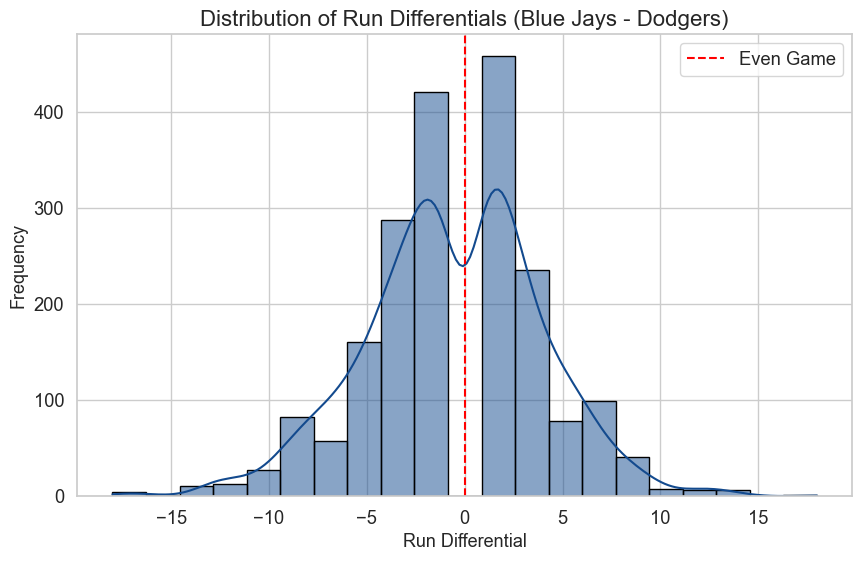

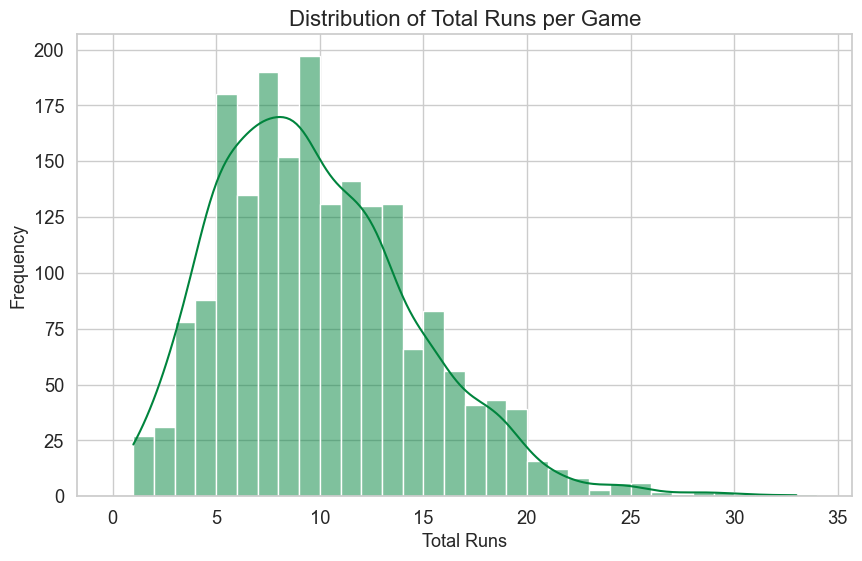

C:\Users\Bradley\AppData\Local\Temp\ipykernel_2640\4208698156.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="winner", palette=["#134A8E", "#EF3E42"])


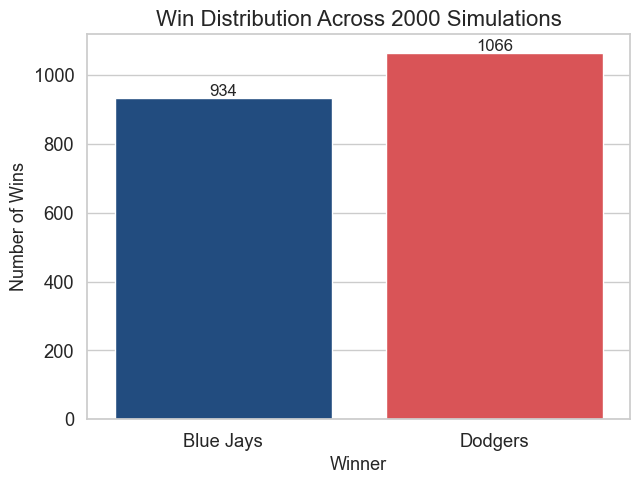

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example simulation loop results
# all_results = [
#     {"game_id": f"Game_{i+1}", "Blue Jays": 5, "Dodgers": 3, "winner": "Blue Jays"}
#     for i in range(1000)
# ]

df = pd.DataFrame(all_results)
df["run_diff"] = df["Blue Jays"] - df["Dodgers"]
df["total_runs"] = df["Blue Jays"] + df["Dodgers"]

sns.set(style="whitegrid", font_scale=1.2, rc={"figure.figsize": (10,6)})

# ------------------------
# 1️⃣ Run Differential Histogram
# ------------------------
plt.figure(figsize=(10,6))
sns.histplot(df["run_diff"], kde=True, bins=21, color="#134A8E", edgecolor="black")
plt.title("Distribution of Run Differentials (Blue Jays - Dodgers)", fontsize=16)
plt.xlabel("Run Differential", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Even Game")
plt.legend()
plt.show()

# ------------------------
# 2️⃣ Total Runs Histogram
# ------------------------
plt.figure(figsize=(10,6))
sns.histplot(df["total_runs"], kde=True, color="#00843D", bins=range(0, max(df["total_runs"])+2))
plt.title("Distribution of Total Runs per Game", fontsize=16)
plt.xlabel("Total Runs", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.show()

# ------------------------
# 3️⃣ Win Probability Bar Chart
# ------------------------
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="winner", palette=["#134A8E", "#EF3E42"])
plt.title(f"Win Distribution Across {n_sims} Simulations", fontsize=16)
plt.xlabel("Winner", fontsize=13)
plt.ylabel("Number of Wins", fontsize=13)

# Add text labels
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2., p.get_height() + 5,
             f"{int(p.get_height())}", ha="center", fontsize=12)
plt.show()


### Write Results to CSV

In [ ]:
# results_df.to_csv(f"data/sim_results_{n_sims}.csv", index=False)
# # save each boxscore separately if you want to inspect later
# import pickle
# with open("data/sim_boxscores.pkl", "wb") as f:
#     pickle.dump(boxscores, f)
